<a href="https://colab.research.google.com/github/manoj-dhakal/machine-learning/blob/main/preTrained_resnet__MultiClass_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from torchvision import datasets
import torchvision.transforms as transforms
import collections
import torchsummary
from torchvision import utils
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchsummary import summary
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch
%matplotlib inline
import os


In [ ]:
print(os.getcwd())
path = '/kaggle/working/data'
if not os.path.exists(path):
    os.makedirs(path, exist_ok=True)

/content


In [ ]:
transf = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path,download=True,
                          split='train',
                          transform=transf)


100%|██████████| 2640397119/2640397119 [00:51<00:00, 51306013.27it/s]


Extracting /kaggle/working/data/stl10_binary.tar.gz to /kaggle/working/data


In [ ]:

test_all = datasets.STL10(path,
                          download=True,
                          split='test',
                          transform=transf) #test all is an object, converted to tensor


Files already downloaded and verified


In [ ]:
count = 0
for data, label in test_all: #test_all is iterable and holds individual data
  count += 1
print(count)

8000


In [ ]:
# Get the numpy array data
print(f'Shape of training set: {train_ds.data.shape}')
print(f'Shape of test set: {test_all.data.shape}')  # both evaluation & test sets


Shape of training set: (5000, 3, 96, 96)
Shape of test set: (8000, 3, 96, 96)


In [ ]:
# Count the number of images per category
y_train = [y for _,y in train_ds] #labels
counter_train = collections.Counter(y_train)
print('Class Image Counter for Training Data')
print(counter_train,'\n')

Class Image Counter for Training Data
Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500}) 



In [ ]:
# Count the number of images per category
y_testall = [y for _,y in test_all] #labels
counter_testall = collections.Counter(y_testall)
print('Class Image Counter for Test Data')
print(counter_testall)

Class Image Counter for Test Data
Counter({6: 800, 7: 800, 5: 800, 0: 800, 3: 800, 1: 800, 4: 800, 9: 800, 2: 800, 8: 800})


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset


split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.2,
                               random_state=0) #creating an instance of StratifiedShuffleSplit class, random_state is just a seed for random, n_split
                               #means data will have 1 split and test_size will be 20% of the split

indices = list(range(len(test_all))) # make index list for upto max value
y_test0 = [y for _,y in test_all]    # extract list of all class labels

for idx_test, idx_val in split.split(indices, y_test0): #split.split() is an iterable object, that can only be broken down by iterating
  break
print(idx_test)



[2096 4321 2767 ... 3206 3910 2902]


In [ ]:

val_ds = Subset(test_all,
                idx_val)  # list of indicies for valid split
test_ds = Subset(test_all,
                 idx_test) # list of indicies for test split

In [ ]:
y_test = [y for _,y in test_ds]
y_val = [y for _,y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)


Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


In [ ]:
conv_dict = {0:"Aircraft", 1:"Bird", 2: "Automobile", 3: "Cat", 4:"Deer", 5:"Dogs", 6:"Horse", 7:"Monkey", 8:"Ship", 9:"Truck"
}

In [ ]:
#plotting

def plot_img(img,y=None,color=True):
    npimg = img.numpy()
    npimg_T = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg_T)
    plt.title(conv_dict[y])
    plt.axis('on')

    #Aircraft (0), Birds (1), Automobiles (2), Cats (3), Deers (4), Dogs (5), Horses (6), Monkeys (7), Ships (8), Trucks (9); a total of 10 classes.

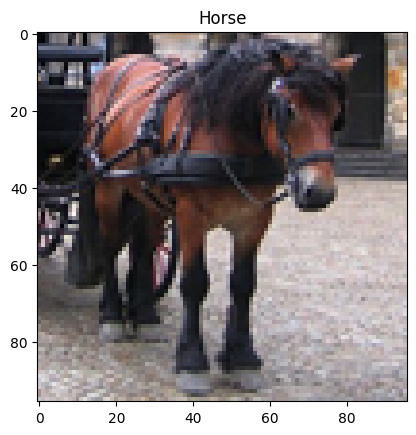

In [ ]:
val_loader = iter(val_ds)

# Iterate over the iterator to get different images and labels in each iteration
for i in range(4):
    # Get the next data item from the iterator
    img, label = next(val_loader)

# Process the data or plot the image here
plot_img(img=img, y=label)


In [ ]:
print(val_ds[0][0])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [ ]:
def get_meanstd(data):

    # list of lists of mean values for each image
    meanRGB = [np.mean(x.numpy(),axis=(1,2)) for x,_ in data]
    stdRGB = [np.std(x.numpy(),axis=(1,2)) for x,_ in data]
    print('Mean & std values for sample:')
    print(meanRGB[0]); print(stdRGB[0])

    # global dataset mean of those means
    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    # global dataset standard deviation mean
    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print('\nMean value for dataset:')
    print(f'Mean Values: {meanR} {meanG} {meanB}')
    print(f'STD Values: {stdR} {stdG} {stdB}')

    return [meanR,meanG,meanB],[stdR,stdG,stdB]

means,stds = get_meanstd(train_ds)

Mean & std values for sample:
[0.5199615  0.47785485 0.34138668]
[0.12017056 0.12164892 0.10806711]

Mean value for dataset:
Mean Values: 0.44671058654785156 0.4398098587989807 0.4066464602947235
STD Values: 0.22414584457874298 0.2214890569448471 0.2238997519016266


In [ ]:
''' Define the image transformations ( for train_ds & test_all) '''

# Transformations for training set
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([means[0],means[1],means[2]],
                                                             [stds[0],stds[1],stds[2]])])

# Standard transformations for test set
test0_transformer = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([means[0],means[1],means[2]],
                                                             [stds[0],stds[1],stds[2]])])

''' Update the transform functions for train_ds & test_all '''
train_ds.transform = train_transformer
test_all.transform = test0_transformer


In [ ]:
''' Create dataloaders from train_ds & val_ds '''

# Create Data Loaders (training)
train_dl = DataLoader(train_ds,
                      batch_size=32,
                      shuffle=True)

# Create Data Loader (validation)
val_dl = DataLoader(val_ds,
                    batch_size=64,
                    shuffle=False)



# And get a batch of data from train_dl
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

# Extract a batch of data from val_dl
for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break


torch.Size([32, 3, 96, 96])
torch.Size([32])
torch.Size([64, 3, 96, 96])
torch.Size([64])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
''' Non Pretrained Model Variant '''
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,10)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
losses = []
val_losses = []
# Define the training function
def train(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    patience = 5 #for early stopping
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_correct = 0
        total_samples = 0
        for batch_data, batch_labels in train_loader:

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += batch_labels.size(0)
            total_correct += (predicted == batch_labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = 100.0 * total_correct / total_samples
        losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += batch_labels.size(0)
                total_correct += (predicted == batch_labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * total_correct / total_samples
        val_losses.append(val_loss)

        # Print progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
            break
train(model, train_dl, val_dl, 10, 0.001) #training this multiple times so that wed don't exhaust the GPU


Epoch 1/10, Train Loss: 0.4758, Val Loss: 0.8223, Train Accuracy: 83.88%, Val Accuracy: 73.88%
Epoch 2/10, Train Loss: 0.4054, Val Loss: 0.8087, Train Accuracy: 86.00%, Val Accuracy: 74.25%
Epoch 3/10, Train Loss: 0.3720, Val Loss: 0.8607, Train Accuracy: 86.92%, Val Accuracy: 74.31%
Epoch 4/10, Train Loss: 0.3317, Val Loss: 0.7859, Train Accuracy: 88.92%, Val Accuracy: 76.19%
Epoch 5/10, Train Loss: 0.3354, Val Loss: 0.6783, Train Accuracy: 88.58%, Val Accuracy: 78.94%
Epoch 6/10, Train Loss: 0.2843, Val Loss: 0.8066, Train Accuracy: 90.34%, Val Accuracy: 74.62%
Epoch 7/10, Train Loss: 0.2810, Val Loss: 0.8456, Train Accuracy: 91.32%, Val Accuracy: 75.25%
Epoch 8/10, Train Loss: 0.3146, Val Loss: 0.6893, Train Accuracy: 89.54%, Val Accuracy: 79.44%
Epoch 9/10, Train Loss: 0.2047, Val Loss: 0.8811, Train Accuracy: 93.06%, Val Accuracy: 76.88%
Epoch 10/10, Train Loss: 0.2094, Val Loss: 0.7869, Train Accuracy: 92.96%, Val Accuracy: 78.62%
Early stopping at epoch 4. Best validation loss: 

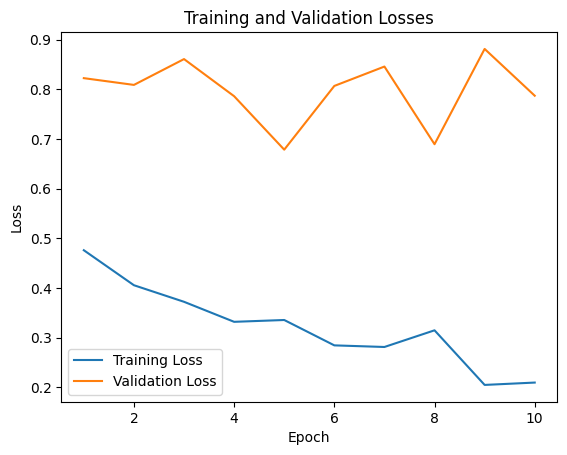

In [ ]:

training_stopped_epoch = 10
# Plotting the losses and validation losses
plt.plot(range(1, training_stopped_epoch+1), losses, label="Training Loss")
plt.plot(range(1, training_stopped_epoch+1), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()




In [ ]:
def round(x):
  _, max = torch.max(x, dim = 1)
  return conv_dict[max.item()]

In [ ]:
#predicting output of one data:
def predict(x, new_image = False): #new image are those images that do not require permutations
  model.eval()

  if len(x.shape) == 3:
    x = x.unsqueeze(0)
  if not new_image:
    x = x.permute(0, 3, 1, 2)

  x = x.to(device)

  pred = model(x)
  return round(pred)


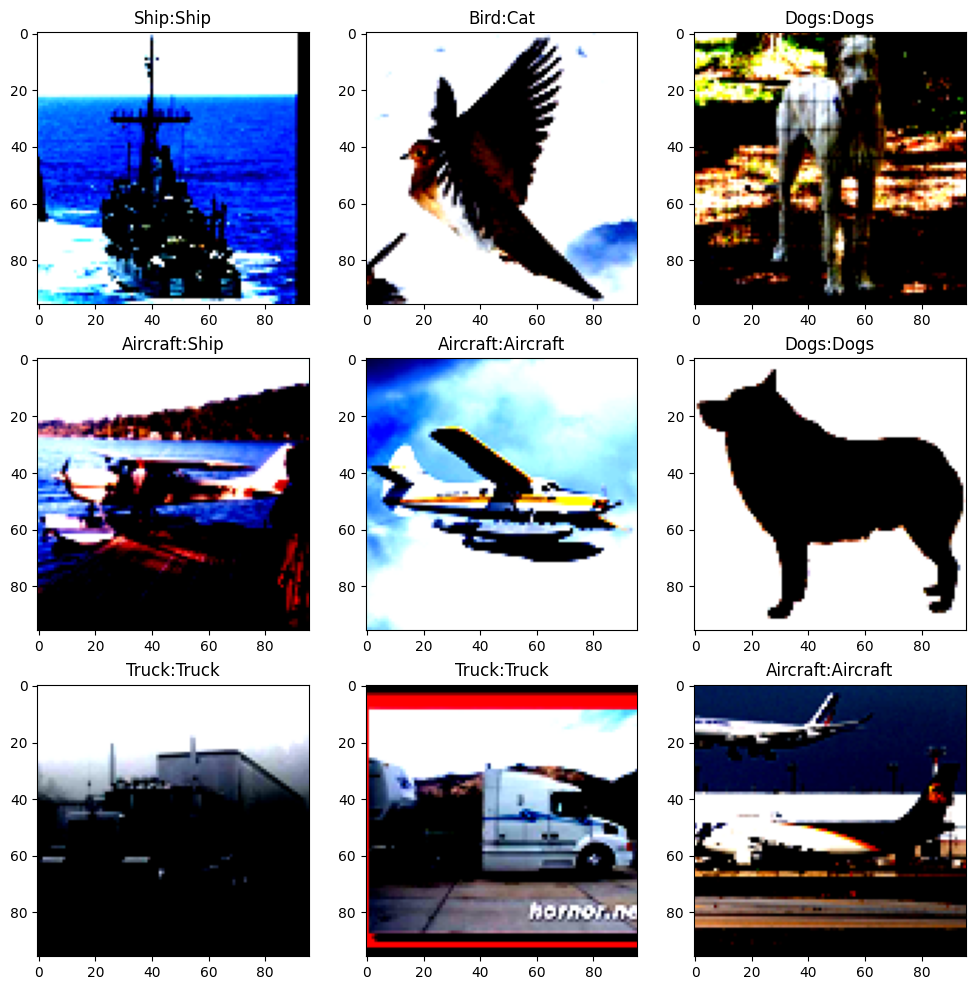

In [ ]:
#visualizing the results
import random
count = 0
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(1,10):
  random_index = random.randint(0, len(test_ds)-1)
  random_image = test_ds[random_index][0].to(device)
  label = test_ds[random_index][1]
  model_answer = predict(random_image, new_image = True)
  ax = plt.subplot(3, 3, i)

  random_image = random_image.cpu().numpy().transpose((1, 2, 0))
  plt.imshow(random_image)
  plt.title(str(conv_dict[label]) + ":" + str(model_answer))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
save_path = "/content/drive/My Drive/Colab Notebooks/model_checkpoint_pretrained_multiclass.pt"
# Save the model checkpoint
torch.save(model.state_dict(), save_path)
